<a href="https://colab.research.google.com/github/Salimovsky/StockML/blob/master/Microsoft_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microsoft stock price prediction

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1F8Dxp97s91mtbj8ipbcgZCZhb6k34bVY#scrollTo=pa49bUnKyRgF"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Salimovsky/StockML/blob/master/Microsoft_stock_price_prediction.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This an initial attempt to predict stock market movement of a specific stock by using time series prediction using Recurrent Neural Networks (RNNs). This is covered in two parts: first, we will forecast a univariate time series, then we will forecast a multivariate time series.

In [1]:
## Install TA library module:
def install_TA_Lib():
  # use this if running on dedicated server machine (ex: JupiterLab)
  # !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  # !tar -xzvf ta-lib-0.4.0-src.tar.gz
  # %cd ta-lib
  # !./configure --prefix=/usr
  # !make
  # !make install
  # !pip install Ta-Lib

  # OR install TA lib binary, in case running on Colab (no dedicated server machine)
  # !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
  # !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
  # !dpkg -i libta.deb ta.deb
  # !pip install Ta-Lib
  print("Uncomment this code to install TA-Lib first time you run this script!")

install_TA_Lib()

Uncomment this code to install TA-Lib first time you run this script!


In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import talib

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

## Microsoft stock dataset
This project uses data from <a href="https://polygon.io/" class="external">Polygon Financial data platform</a> fetched using a kotlin client program of Polygon Rest API <a href="https://polygon.io/docs/#get_v2_aggs_ticker__ticker__range__multiplier___timespan___from___to__anchor" class="external"></a>.

This dataset contains 33 different features such as price, volume, time, moving average, and OCHL. These were aggregates of trades for every 1 minute, beginning in 2019/01/01. This dataset was prepared by me for the purpose of this project.

MSFT timestampMs, 
MSFT monthOfYear, 
MSFT dayOfMonth, 
MSFT dayOfWeek, 
MSFT hourOfDay, 
MSFT minuteOfHour, 
MSFT volume, 
MSFT weightedPrice, 
MSFT open, 
MSFT high, 
MSFT low, 
MSFT close, 
MSFT Days Avg 3 Low, 
MSFT Days Avg 3 Weighted, 
MSFT Days Avg 3 High, 
MSFT Days Avg 5 Low, 
MSFT Days Avg 5 Weighted, 
MSFT Days Avg 5 High, 
MSFT Days Avg 10 Low, 
MSFT Days Avg 10 Weighted, 
MSFT Days Avg 10 High, 
MSFT Days Avg 20 Low, 
MSFT Days Avg 20 Weighted, 
MSFT Days Avg 20 High, 
MSFT Days Avg 50 Low, 
MSFT Days Avg 50 Weighted, 
MSFT Days Avg 50 High, 
MSFT Days Avg 100 Low, 
MSFT Days Avg 100 Weighted, 
MSFT Days Avg 100 High, 
MSFT Days Avg 200 Low, 
MSFT Days Avg 200 Weighted, 
MSFT Days Avg 200 High, 

In [0]:
# The raw dat file is located in my personal google drive, and is shared to the public. Please email me at salim.addi@gmail.com if You can't download the file anymore!
# uncomment this line to remove cached file if you need to reload an updated version of raw data file
#!rm ~/.keras/datasets/MSFT.csv
file_path = tf.keras.utils.get_file(
    origin='https://docs.google.com/uc?export=download&id=14Y3yvzY8CEIIg-C4vX4HsSwJxGU3sx7B',
    fname='MSFT.csv',
    extract=False)
df = pd.read_csv(file_path, sep='|')

Let's take a glance at the data.

In [4]:
df.head()

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,MSFT Days Avg 20 High,MSFT Days Avg 50 Low,MSFT Days Avg 50 Weighted,MSFT Days Avg 50 High,MSFT Days Avg 100 Low,MSFT Days Avg 100 Weighted,MSFT Days Avg 100 High,MSFT Days Avg 200 Low,MSFT Days Avg 200 Weighted,MSFT Days Avg 200 High
0,1546419600000,1,2,4,3,0,387.0,99.4000,99.40,99.40,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
1,1546419840000,1,2,4,3,4,371.0,98.9013,98.88,98.88,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
2,1546420320000,1,2,4,3,12,100.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
3,1546420500000,1,2,4,3,15,380.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
4,1546420980000,1,2,4,3,23,188.0,99.2330,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615


In [0]:
from talib import MA_Type

## Technical Analysis Indicators
ta_weighted_price = 'MSFT weightedPrice'
ta_volume = 'MSFT volume'
ta_time_stamp = 'MSFT timestampMs'
ta_obv = 'MSFT OBV'

wighted_prices = df[ta_weighted_price].values
open = df['MSFT open'].values
high = df['MSFT high'].values
low = df['MSFT low'].values
close = df['MSFT close'].values
volume = df[ta_volume].values

price_SMA_50 = talib.SMA(wighted_prices, timeperiod=50)
price_SMA_100 = talib.SMA(wighted_prices, timeperiod=100)
price_SMA_200 = talib.SMA(wighted_prices, timeperiod=200)
price_DEMA_5 = talib.DEMA(wighted_prices, timeperiod=5)
price_DEMA_10 = talib.DEMA(wighted_prices, timeperiod=10)
price_DEMA_20 = talib.DEMA(wighted_prices, timeperiod=20)
bbands_20 = talib.BBANDS(wighted_prices, timeperiod=20, matype=MA_Type.T3)
bbands_10 = talib.BBANDS(wighted_prices, timeperiod=10, matype=MA_Type.T3)
rsi_14 = talib.RSI(wighted_prices, timeperiod=14)
stoch_14 = talib.STOCH(high, low, wighted_prices, fastk_period=14)
obv = talib.OBV(wighted_prices, volume)
macd = talib.MACD(wighted_prices, fastperiod=12, slowperiod=26, signalperiod=9)


df['MSFT SMA 50'] = price_SMA_50
df['MSFT SMA 100'] = price_SMA_100
df['MSFT SMA 200'] = price_SMA_200
df['MSFT DEMA 5'] = price_DEMA_5
df['MSFT DEMA 10'] = price_DEMA_10
df['MSFT DEMA 20'] = price_DEMA_20
df['MSFT BBANDS 20 UPPER'], df['MSFT BBANDS 20 MIDDLE'], df['MSFT BBANDS 20 LOWER'] = bbands_20
df['MSFT BBANDS 10 UPPER'], df['MSFT BBANDS 10 MIDDLE'], df['MSFT BBANDS 10 LOWER'] = bbands_10
df['MSFT RSI 14'] = rsi_14
df['MSFT STOCH 14 lowk'], df['MSFT STOCH 14 lowd'] = stoch_14
df[ta_obv] = obv
df['MSFT macd'], df['MSFT macdsignal'], df['MSFT macdhist']= macd

In [6]:
df.tail(10)

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,MSFT BBANDS 10 UPPER,MSFT BBANDS 10 MIDDLE,MSFT BBANDS 10 LOWER,MSFT RSI 14,MSFT STOCH 14 lowk,MSFT STOCH 14 lowd,MSFT OBV,MSFT macd,MSFT macdsignal,MSFT macdhist
136995,1577838600000,12,31,3,18,30,462.0,157.7436,157.74,157.74,...,157.942869,157.850329,157.757788,39.418568,14.379545,40.805808,132270692.0,0.001453,0.013947,-0.012494
136996,1577838660000,12,31,3,18,31,9251.0,157.7011,157.72,157.72,...,157.970989,157.843568,157.716147,35.591875,4.780861,22.024428,132261441.0,-0.008927,0.009372,-0.018300
136997,1577838780000,12,31,3,18,33,600.0,157.7333,157.80,157.80,...,157.971127,157.833219,157.695310,40.319135,6.835088,8.665165,132262041.0,-0.014390,0.004620,-0.019010
136998,1577839140000,12,31,3,18,39,322.0,157.7700,157.77,157.77,...,157.956032,157.821430,157.686828,45.251299,18.315789,9.977246,132262363.0,-0.015578,0.000580,-0.016158
136999,1577839320000,12,31,3,18,42,140.0,157.8000,157.80,157.80,...,157.933668,157.810298,157.686927,48.964231,35.666667,20.272515,132262503.0,-0.013938,-0.002323,-0.011615
137000,1577839920000,12,31,3,18,52,177.0,157.7700,157.77,157.77,...,157.908729,157.800151,157.691572,45.631555,42.105263,32.029240,132262326.0,-0.014888,-0.004836,-0.010052
137001,1577839980000,12,31,3,18,53,800.0,157.8000,157.80,157.80,...,157.893345,157.791887,157.690430,49.344555,47.368421,41.713450,132263126.0,-0.013069,-0.006483,-0.006586
137002,1577840220000,12,31,3,18,57,166.0,157.7810,157.78,157.78,...,157.857961,157.785330,157.712699,47.148405,44.035088,44.502924,132262960.0,-0.013011,-0.007788,-0.005222
137003,1577840280000,12,31,3,18,58,1183.0,157.8307,157.78,157.84,...,157.853141,157.781437,157.709734,53.036451,54.684211,48.695906,132264143.0,-0.008852,-0.008001,-0.000851
137004,1577840340000,12,31,3,18,59,200.0,157.8500,157.85,157.85,...,157.865980,157.780747,157.695515,55.127108,63.456140,54.058480,132264343.0,-0.003954,-0.007192,0.003238


The technical indicators functions needs some initial datapoints before they could calculate output...before then they will NaN. Lets see how many of them we have:

In [7]:
nan_list = [price_SMA_50, price_SMA_100, price_SMA_200, *bbands_20, rsi_14, *macd]
for i in nan_list:
  print(np.count_nonzero(np.isnan(i)))

49
99
199
114
114
114
14
33
33
33


As you can see above, an aggregate is recorded every 1 mintue. This means that, for a single hour, you will have 60 datapoint.

Given a specific time, let's say we want to predict the stock price 5 minutes in the future. In order to make this prediction, you choose to use 60 minutes of past stock datapoints. Thus, you would create a window containing the last 60 datapoints to train the model.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Function to plot the training/validation loss history during training

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(12,6))

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In this project, we will train our model on 85% of the dataset, and the remaining will be the validation dataset. This amounts to ~460 days worth of training data.

In [10]:
TRAIN_SPLIT = np.long(df[ta_weighted_price].values.size * 0.85)
print("Training set size = %s" % (TRAIN_SPLIT))

Training set size = 116454


Setting seed to ensure reproducibility.

In [0]:
tf.random.set_seed(13)

## Part 1: Predict a univariate time series
First, we will train a model using only a single feature (stock price weighted by volume), and use it to make predictions for that value in the future.

Let's first extract only the stock weighted price from the dataset.

In [12]:
uni_data = df[ta_weighted_price]
uni_data.index = df[ta_time_stamp]
uni_data.head()

MSFT timestampMs
1546419600000    99.4000
1546419840000    98.9013
1546420320000    99.2000
1546420500000    99.2000
1546420980000    99.2330
Name: MSFT weightedPrice, dtype: float64

Let's observe how this data looks across time (Jan 2019 till May 2020).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f75d8f06f50>],
      dtype=object)

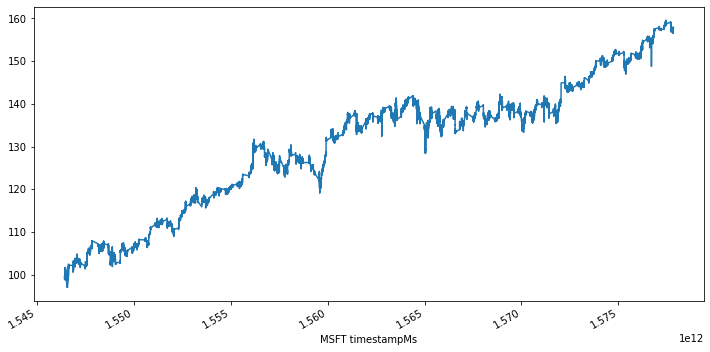

In [13]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

Here we normalize our data using the mean and standard deviation of the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 60 stock prices, and needs to learn to predict the stock price at the next time step. 

In [0]:
univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

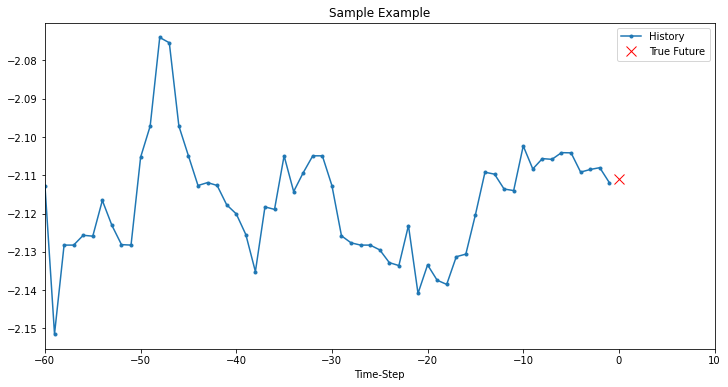

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Recurrent neural network

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_univariate = train_univariate.take(k).cache().repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
print(x_train_uni.shape)

(116394, 60, 1)


Define the optimizers we will be experimenting with:

In [0]:
optmzer_rms=tf.keras.optimizers.RMSprop()
optmzer_adam=tf.keras.optimizers.Adam(learning_rate=0.00001)

Define a simple LSTM model:

In [24]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
    ])

simple_lstm_model.summary()
simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 2000 steps on JupyterLab (or 200 on Colab), instead of the complete training data as normally done.

In [25]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
single_step_univar_loss_history = simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=100, 
                      callbacks=[early_stopping]
                      )

Epoch 1/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0055 - mean_absolute_percentage_error: 7.1152 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 2.2415
Epoch 2/10
2000/2000 [==============================] - 15s 7ms/step - loss: 1.3708e-04 - mean_absolute_percentage_error: 5.8161 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 1.3902
Epoch 3/10
2000/2000 [==============================] - 15s 7ms/step - loss: 1.5161e-04 - mean_absolute_percentage_error: 5.5518 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 3.8280
Epoch 4/10
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1594e-04 - mean_absolute_percentage_error: 6.7873 - val_loss: 1.2571e-04 - val_mean_absolute_percentage_error: 0.4216
Epoch 5/10
2000/2000 [==============================] - 15s 8ms/step - loss: 1.1534e-04 - mean_absolute_percentage_error: 6.3425 - val_loss: 4.4589e-04 - val_mean_absolute_percentage_error: 0.8762
Epoch 6/10
2000/2000 [=========

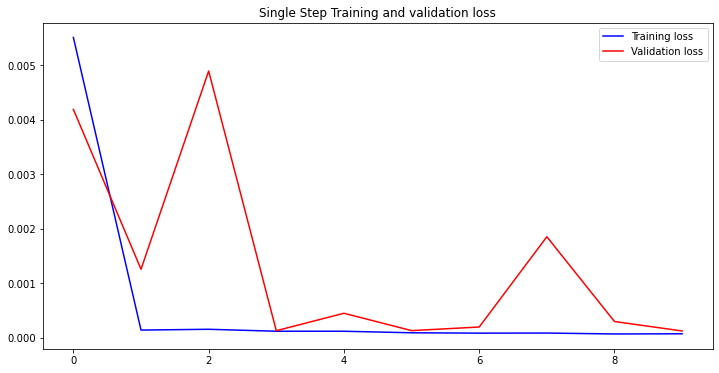

In [26]:
plot_train_history(single_step_univar_loss_history,
                   'Single Step Training and validation loss')

#### Predict using the simple LSTM model
Now that we have trained our simple LSTM, let's try and make a few predictions.

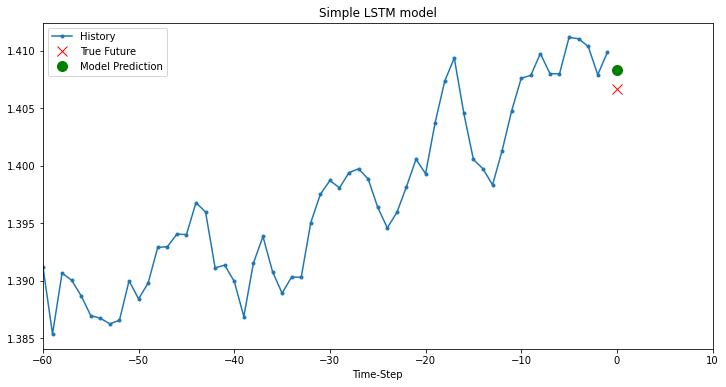

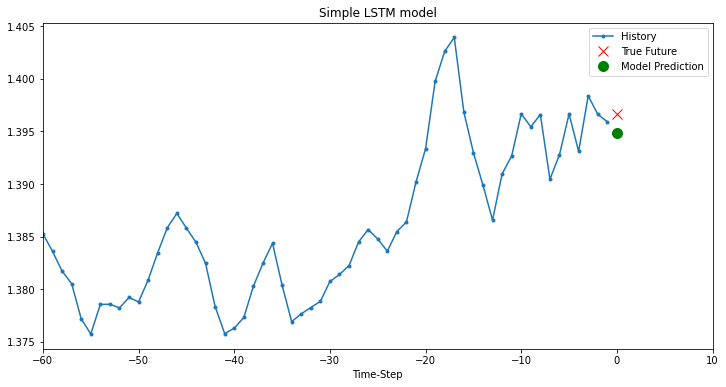

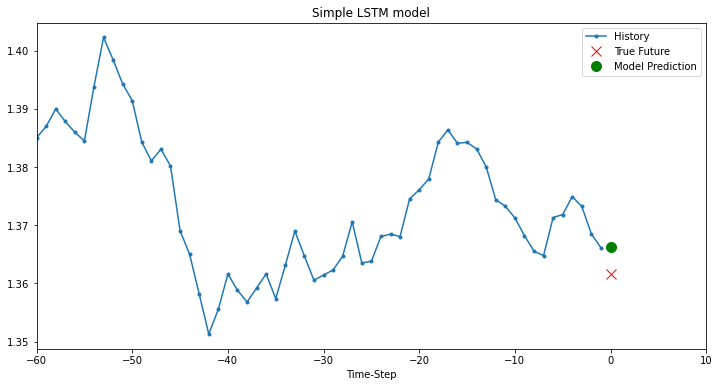

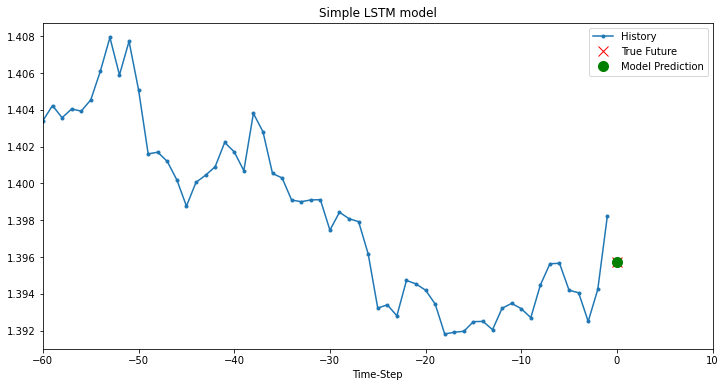

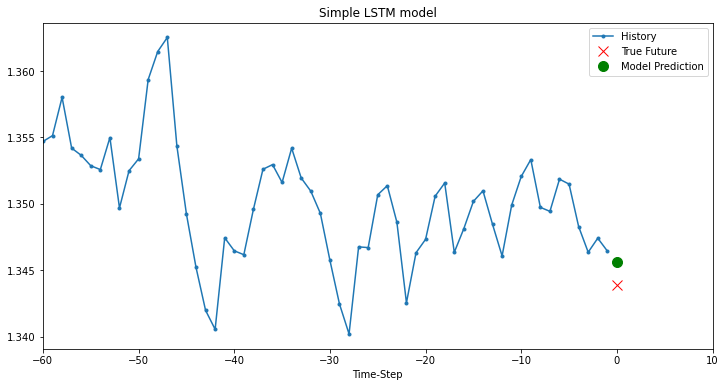

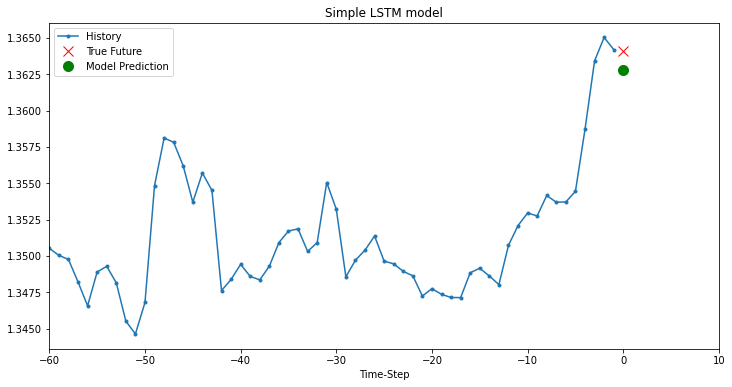

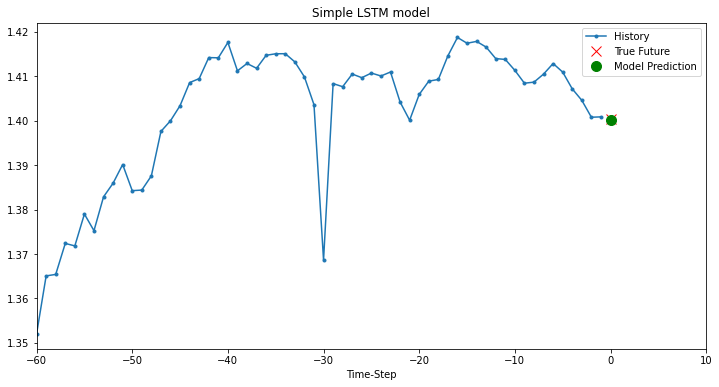

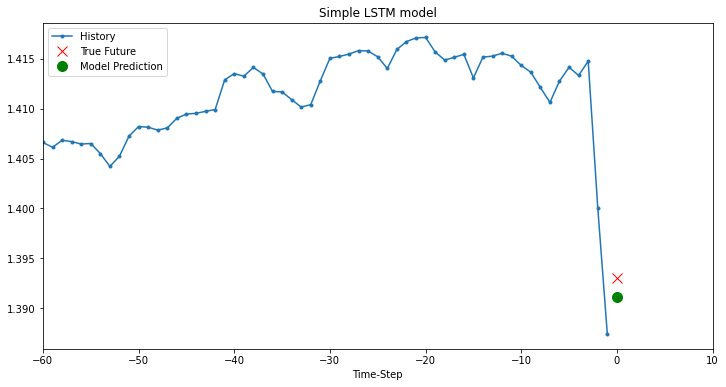

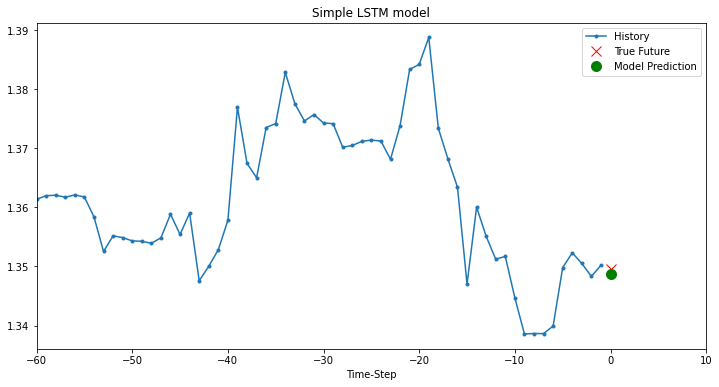

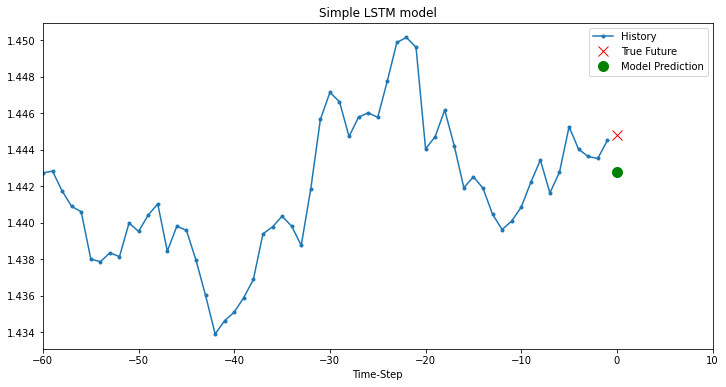

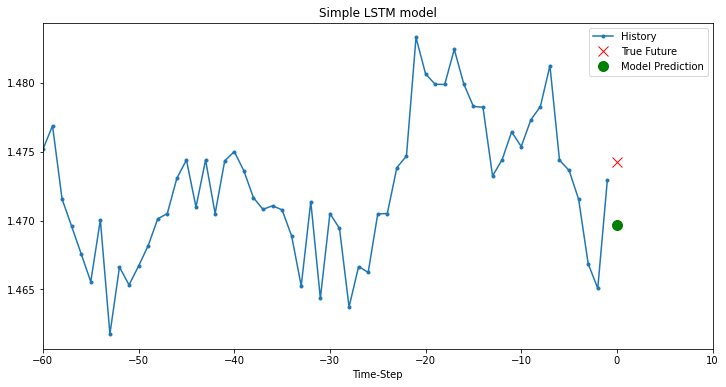

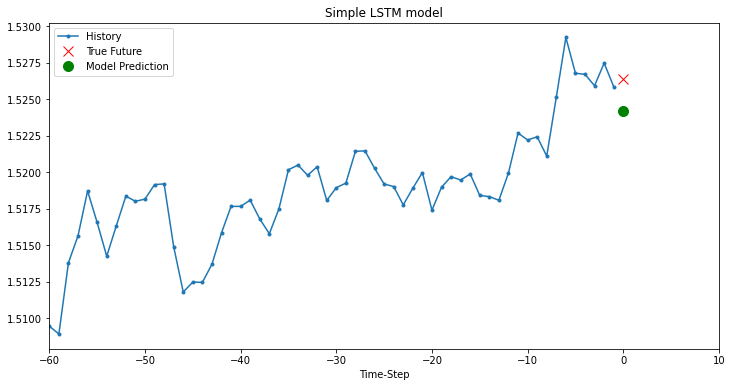

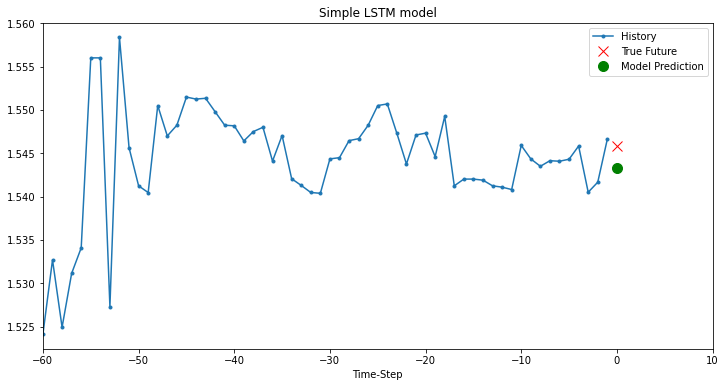

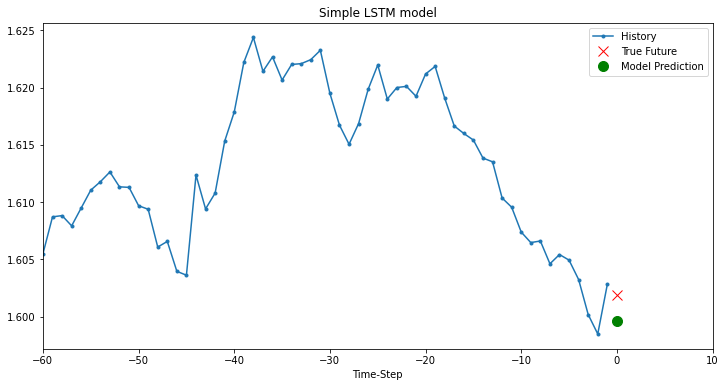

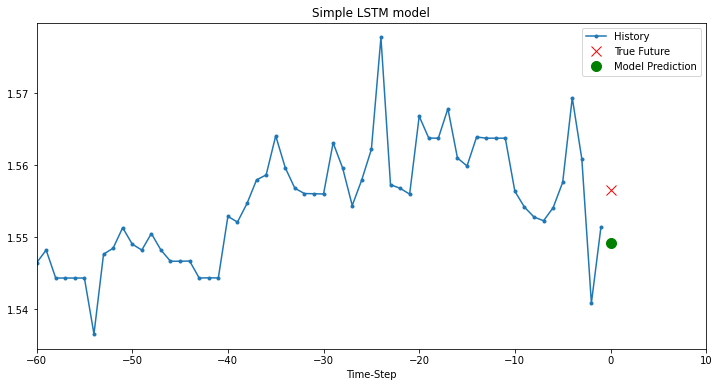

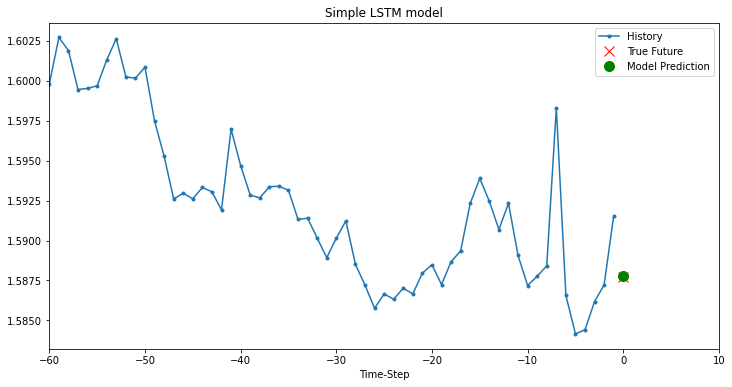

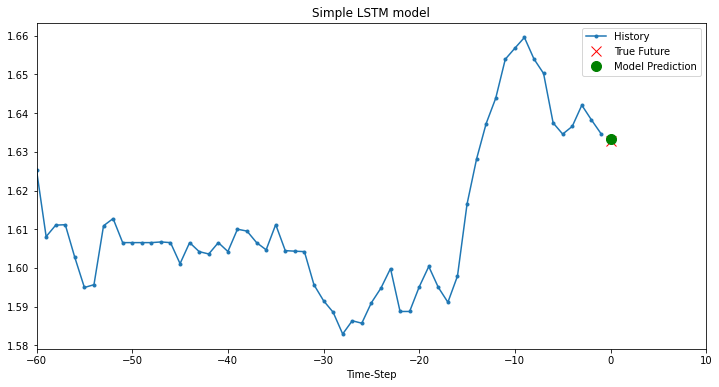

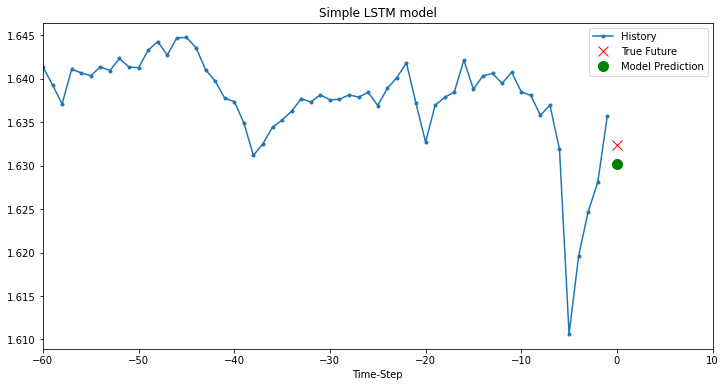

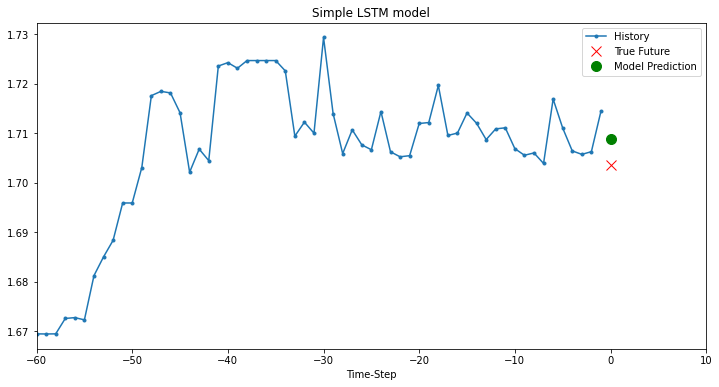

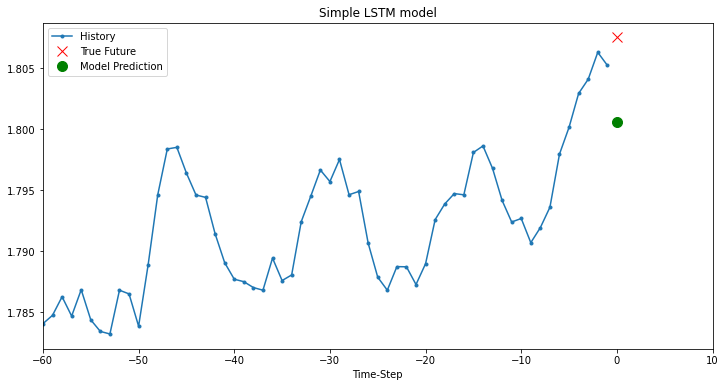

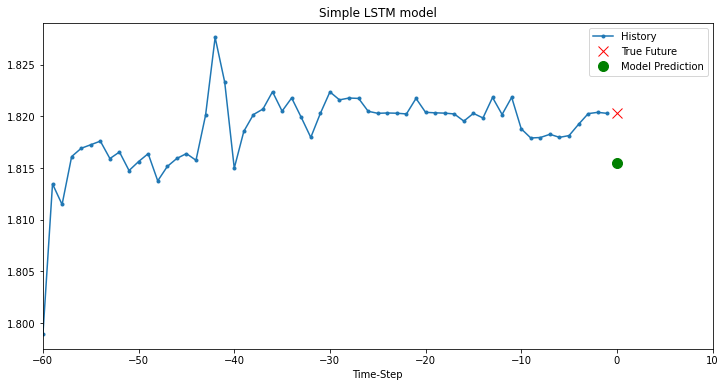

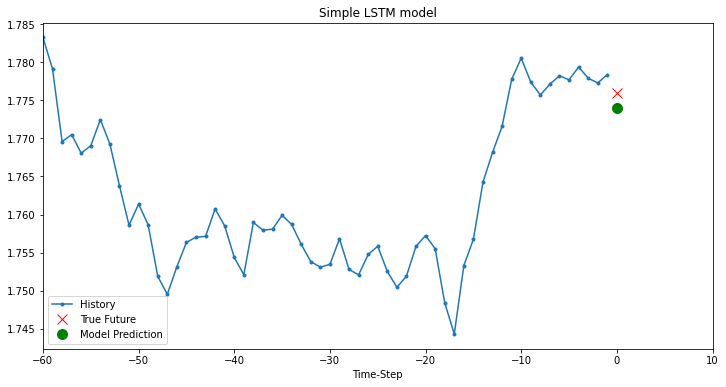

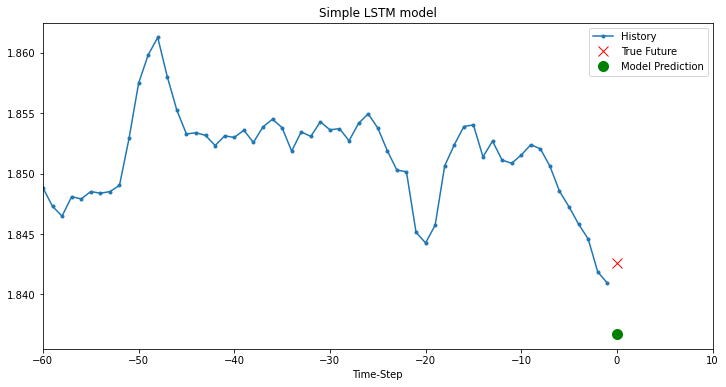

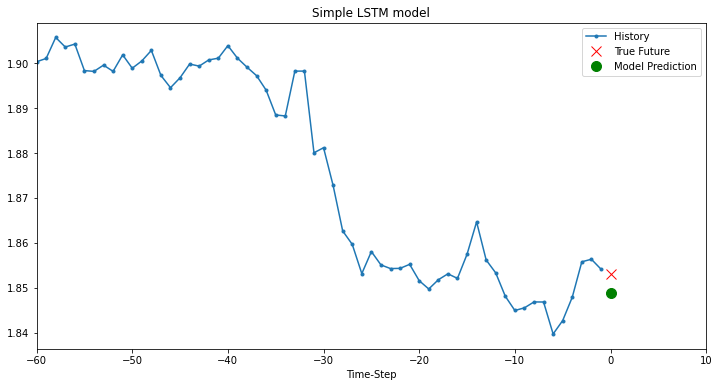

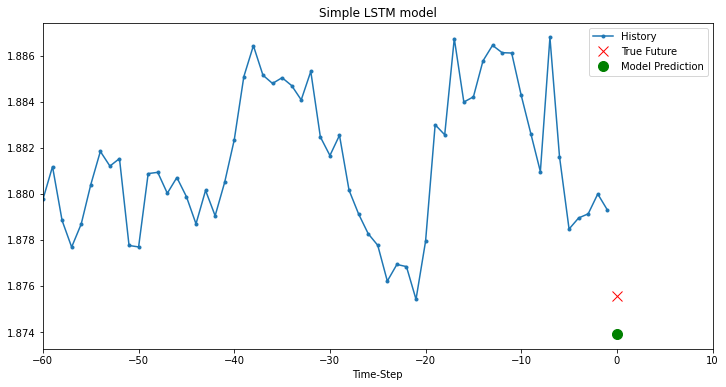

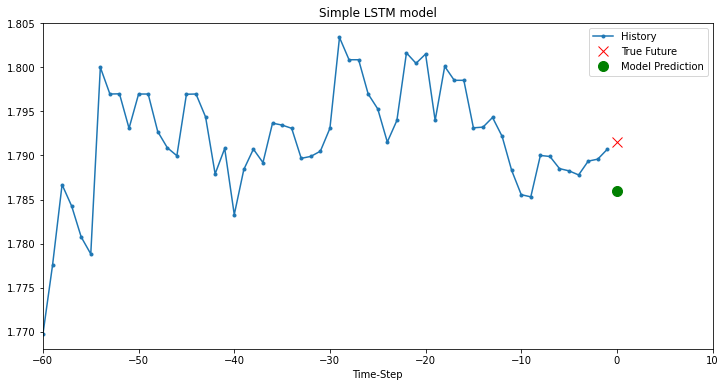

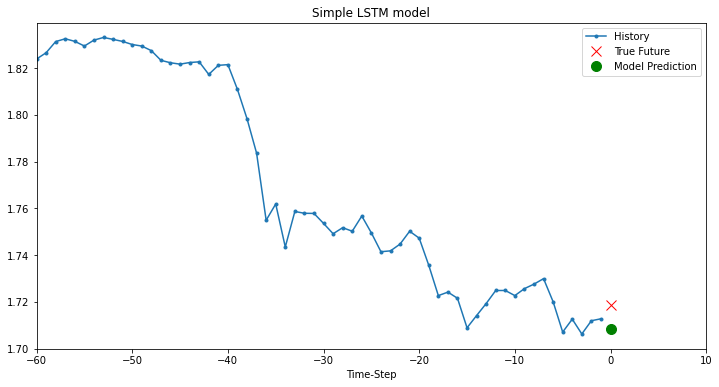

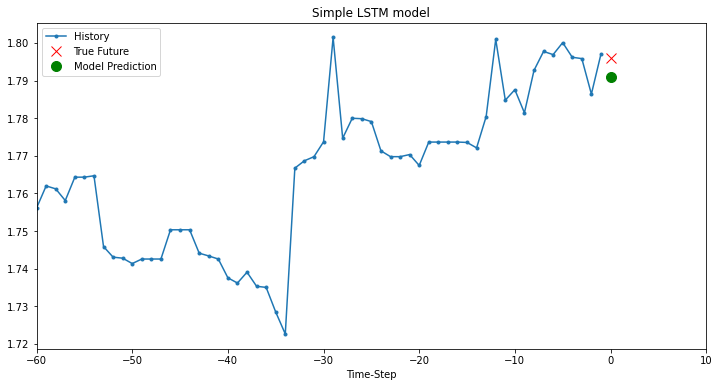

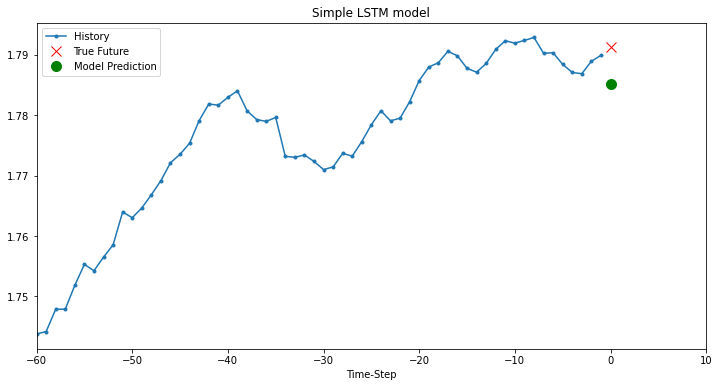

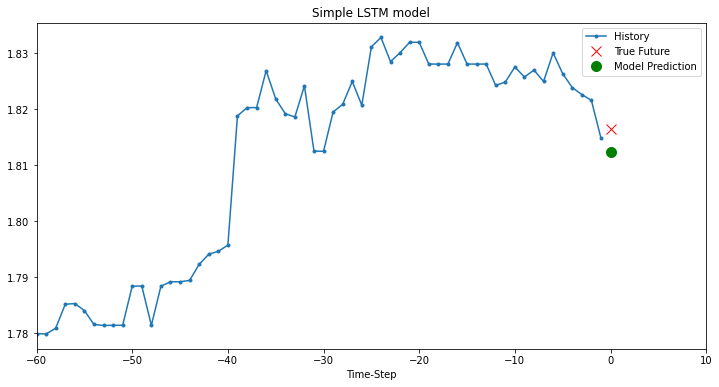

In [27]:
for x, y in val_univariate.take(30):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Predict a multivariate time series

The original dataset contains 32 features. And we added more features by extracting technical analysis indicators from OCHL data.

In [0]:

indicators_price_volume = [ta_weighted_price, ta_volume]
price_index = 0 # index of 'MSFT weightedPrice'
indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
indicators_volume =  [ta_obv]


We will standardize some features in the dataset using the mean and standard deviation of the training data. Other features do not need to be normalized.

In [0]:
# indicators_price_volume = [ta_weighted_price, ta_volume]
# indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
# indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
# indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
# indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
# indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
# indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
# indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
# indicators_volume =  [ta_obv]

prices_dataset = df[ta_weighted_price].values
volume_dataset = df[ta_volume].values
time_dataset = df[indicators_time].values
ochl_dataset = df[indicators_ochl].values
long_average_dataset = df[indicators_long_average].values
short_average_dataset = df[indicators_short_average].values
bbands_dataset = df[indicators_bbands].values
momentum_100_dataset = df[indicators_momentum_100].values
momentum_1_dataset = df[indicators_momentum_1].values
obv_dataset = df[ta_obv].values


prices_mean = prices_dataset[:TRAIN_SPLIT].mean(axis=0)
prices_std = prices_dataset[:TRAIN_SPLIT].std(axis=0)
prices_dataset = (prices_dataset - prices_mean)/prices_std
ochl_dataset = (ochl_dataset - prices_mean)/prices_std
long_average_dataset = (long_average_dataset - prices_mean)/prices_std
short_average_dataset = (short_average_dataset - prices_mean)/prices_std
bbands_dataset = (bbands_dataset - prices_mean)/prices_std

volume_mean = volume_dataset[:TRAIN_SPLIT].mean(axis=0)
volume_std = volume_dataset[:TRAIN_SPLIT].std(axis=0)
volume_dataset = (volume_dataset - volume_mean)/volume_std

obv_mean = obv_dataset[:TRAIN_SPLIT].mean(axis=0)
obv_std = obv_dataset[:TRAIN_SPLIT].std(axis=0)
obv_dataset = (obv_dataset - obv_mean)/obv_std

momentum_100_dataset = momentum_100_dataset/100


In [0]:
dataset = np.column_stack((
                           prices_dataset, 
                           volume_dataset, 
                          #  time_dataset, 
                           ochl_dataset, 
                           long_average_dataset, 
                           short_average_dataset, 
                           bbands_dataset, 
                           momentum_100_dataset, 
                           momentum_1_dataset, 
                           obv_dataset
                           ))

# remove first 200 NaN rows
dataset = np.delete(dataset, slice(0,199), 0)



### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of trade aggregations over the past sampled every few minutes. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
prediction_size = 1 # for multi-steps prediction mode, this is the size of future steps to predict
past_history = 60
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, price_index], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 prediction_size, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, price_index],
                                             TRAIN_SPLIT, None, past_history,
                                             prediction_size, STEP)

Let's check out a sample data-point.

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target price to predict : {}'.format(y_train_multi[0].shape))

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, price_index]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every minute.

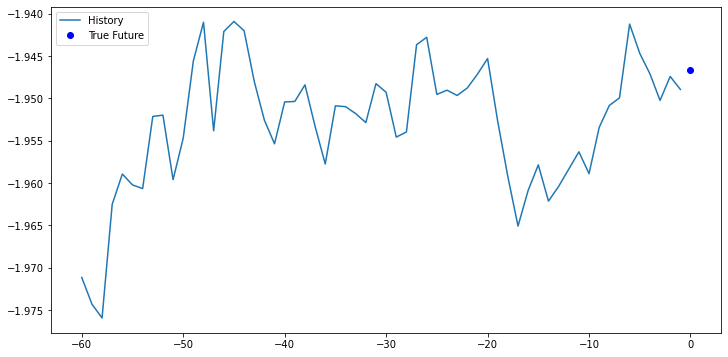

In [36]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Define a more sophisticated model:

In [37]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
#multi_step_model.add(tf.keras.layers.LSTM(128))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(64))
multi_step_model.add(tf.keras.layers.Dense(prediction_size))

multi_step_model.compile(optimizer=optmzer_adam, loss='mse', metrics=['mean_absolute_percentage_error'])

Let's see how the model predicts before it trains.

In [38]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 1)


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100,
                                          callbacks=[early_stopping]
                                          )

Epoch 1/10
2000/2000 [==============================] - 159s 80ms/step - loss: 0.2702 - mean_absolute_percentage_error: 59.0862 - val_loss: 0.1937 - val_mean_absolute_percentage_error: 17.6105
Epoch 2/10
2000/2000 [==============================] - 156s 78ms/step - loss: 0.0012 - mean_absolute_percentage_error: 39.9597 - val_loss: 0.1253 - val_mean_absolute_percentage_error: 13.0650
Epoch 3/10
2000/2000 [==============================] - 157s 79ms/step - loss: 4.3998e-04 - mean_absolute_percentage_error: 22.8492 - val_loss: 0.0828 - val_mean_absolute_percentage_error: 10.5410
Epoch 4/10
2000/2000 [==============================] - 156s 78ms/step - loss: 2.7309e-04 - mean_absolute_percentage_error: 20.5307 - val_loss: 0.0680 - val_mean_absolute_percentage_error: 9.3083
Epoch 5/10
2000/2000 [==============================] - 157s 78ms/step - loss: 2.0901e-04 - mean_absolute_percentage_error: 13.4976 - val_loss: 0.0626 - val_mean_absolute_percentage_error: 8.6471
Epoch 6/10
2000/2000 [===

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well our network has learnt to predict the future.

In [0]:
for x, y in val_data_multi.take(30):
  prediction = multi_step_model.predict(x)[0]
  multi_step_plot(x[0], y[0], prediction)

In [0]:
print(tf.__version__)

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. We may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).